In [8]:
from tkinter import Y

import numpy as np
from skimage import filters
import csv

import matplotlib.pyplot as plt

In [9]:
loc = 'data/new/1304_2d/c5+.csv'

def show_image(image, title):
    # Show Image
    fig, ax = plt.subplots()
    ax.imshow(image, interpolation = 'nearest')
    ax.set_title(f'{title} image')
    fig.set_size_inches([2,2])

def csv_to_image(path):
    # Read in data
    with open(path, newline='\n') as c_file:
        reader = csv.reader(c_file, delimiter=',')
        reader.__next__()       # Skip column definitions

        pixels = [] 

        for row in reader:
            x, y, pixel = int(row[1]), int(row[2]), int(row[3])
            pixels.append((x, y, pixel))    # Store pixel as tuple

    # Get Bounds 
    x_min = min([pixel[0] for pixel in pixels])
    x_max = max([pixel[0] for pixel in pixels])
    y_min = min([pixel[1] for pixel in pixels])
    y_max = max([pixel[1] for pixel in pixels])

    # Generate Numpy Array
    image = np.empty([y_max-y_min+1, x_max-x_min+1])

    for pixel in pixels:
        image[pixel[1] - y_min, pixel[0] - x_min] = pixel[2]

    # Show Image
    show_image(image, path)

    return image



In [76]:
def norm_background(image, title, threshold = 0.75, hard = False, method = 0, processing = False):
    """
    ### Normalize Background
    Returns imaged normalized with respect to background. Method employed is specified by the `method` attribute, which defaults to `0`.
    #### Methods
    - `0` | Everything under `threshold` percentage of the maximum pixel value is background. \n
    \t The `hard` attribute here refers to whether we normalize against the background or do that *and* set the background to zero.
    - `1` | Otsu Thresholding
    """

    # PROCESSING
    if (processing):
        pixl_mean, pixl_std = np.mean(image), np.std(image)
        pixl_shift = pixl_mean + pixl_std
        # Set pixels above shift to mean
        image[image > pixl_shift] = 0

    norm_image = 0

    # 0) SIMPLE THRESHOLD
    if(method == 0):
        max_val = np.max(image)
        threshold = int(threshold * max_val)

    # 1) OTSU
    elif(method == 1):
        threshold = filters.threshold_otsu(image)

    # Make Threshold image
    image_threshold = np.copy(image)
    image_threshold[image_threshold > threshold] = 255
    image_threshold[image_threshold <= threshold] = 0

    show_image(image_threshold, f'THRESHOLD: {title}')

    # Find Background Mean Value    
    bg_indices = np.where(image_threshold == 0)     # Fetch Indices
    avg_bg_value = np.average(image[bg_indices])

    # Normalize against background
    norm_image = (image - avg_bg_value).astype(int)
    norm_image = np.clip(norm_image, 0, 255)

    if hard:
        norm_image[bg_indices] = 0



    return norm_image


In [51]:
def integrate_image(image):
    cum_sum = np.sum(image)
    return cum_sum

TypeError: norm_background() missing 1 required positional argument: 'title'

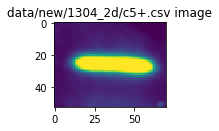

In [5]:
image = csv_to_image('data/new/1304_2d/c5+.csv')
image = norm_background(image)
show_image(image, '')

In [73]:
def integral_analysis(path_band, path_loading, threshold = 0.75, hard = False, method = 0, processing = False):
    # Pre-process
    band_image, load_image = csv_to_image(path_band), csv_to_image(path_loading)
    band_norm = norm_background(band_image, path_band, threshold, hard, method, processing)
    show_image(band_norm, 'PROCESSED (BAND): ' + path_band)
    load_norm = norm_background(load_image, path_loading, threshold, hard, method, processing)
    show_image(load_norm, 'PROCESSED (NORM): ' + path_loading)

    # Integrate
    int_band, int_load = integrate_image(band_norm), integrate_image(load_norm)

    # Enrichment
    norm_magnitude = int_band / int_load
    print(f'Magnitude (normalized): {norm_magnitude}')
    return norm_magnitude

Magnitude (normalized): 1.5026953302591415


1.5026953302591415

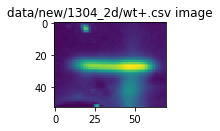

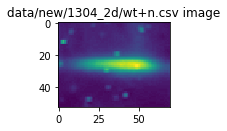

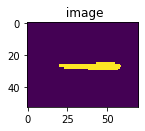

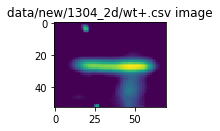

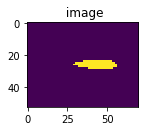

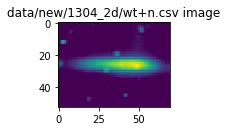

In [6]:
integral_analysis('data/new/1304_2d/wt+.csv', 'data/new/1304_2d/wt+n.csv', threshold = 0.75, hard = False)

In [86]:
def enrichment_analysis(rel_path, suffix, title, threshold = 0.75, hard = False, method = 0, processing = False):
    rp, sf, ex = rel_path, suffix, '.csv'
    p, pn = rp + '/' + sf + '+' + ex, rp + '/' + sf + '+n' + ex
    n, nn = rp + '/' + sf + '-' + ex, rp + '/' + sf + '-n' + ex

    pos_magnitude = integral_analysis(p, pn, threshold, hard, method, processing)
    neg_magnitude = integral_analysis(n, nn, threshold, hard, method, processing)

    enrichment = pos_magnitude / neg_magnitude

    print(f'Enrichment of {title}: {enrichment}')

Magnitude (normalized): 0.7102937913572351
Magnitude (normalized): 0.42240838543879883
Enrichment of c5: 1.681533359285423


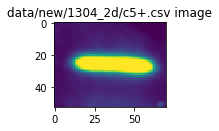

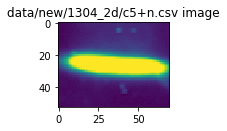

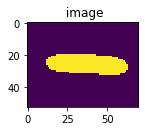

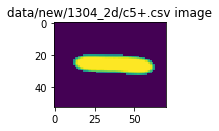

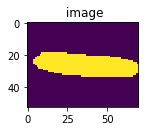

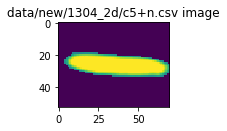

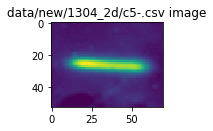

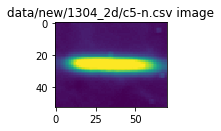

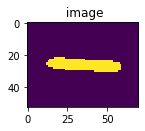

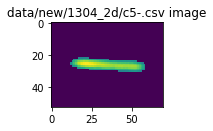

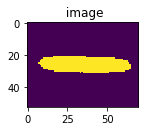

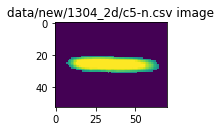

In [8]:
enrichment_analysis('data/new/1304_2d', 'c5', 'c5', threshold = 0.5, hard = True)

Magnitude (normalized): 0.7374376653502961
Magnitude (normalized): 0.6514890639734737
Enrichment of c4: 1.1319263915999085


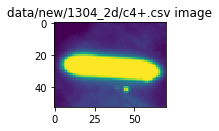

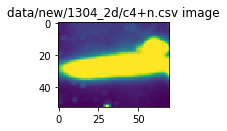

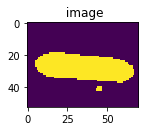

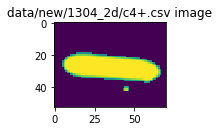

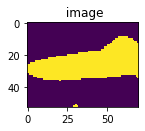

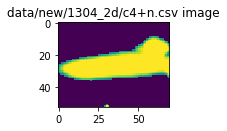

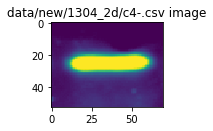

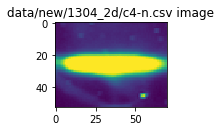

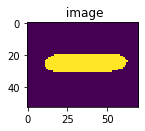

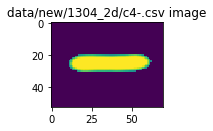

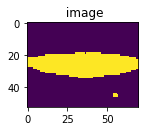

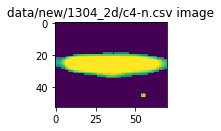

In [17]:
enrichment_analysis('data/new/1304_2d', 'c4', 'c4', threshold = 0.5, hard = True)

Magnitude (normalized): 1.3466486333469632
Magnitude (normalized): 0.6084199199110907
Enrichment of wt: 2.2133539505803013


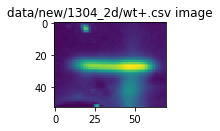

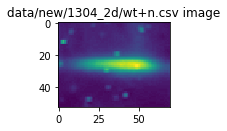

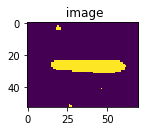

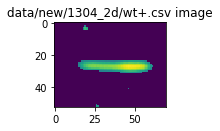

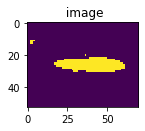

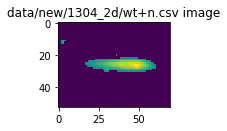

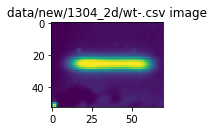

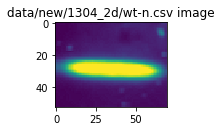

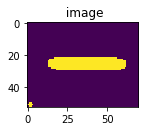

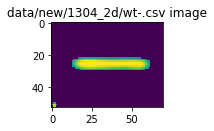

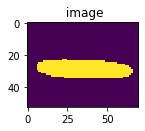

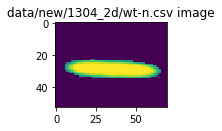

In [18]:
enrichment_analysis('data/new/1304_2d', 'wt', 'wt', threshold = 0.5, hard = True)

Magnitude (normalized): 0.5970845634753269
Magnitude (normalized): 0.42992346308945767
Enrichment of hp: 1.38881595152923


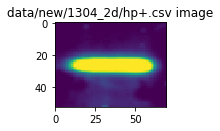

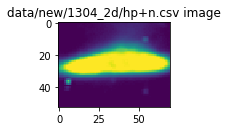

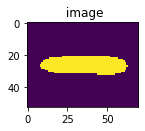

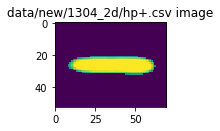

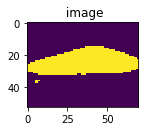

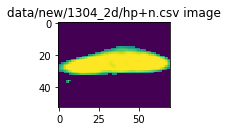

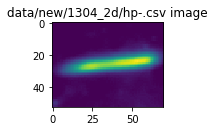

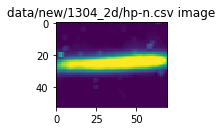

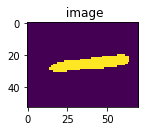

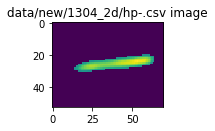

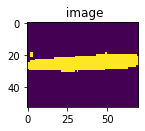

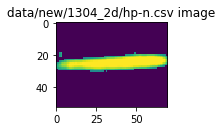

In [19]:
enrichment_analysis('data/new/1304_2d', 'hp', 'hp', threshold = 0.5, hard = True)

Magnitude (normalized): 0.0268052613779969
Magnitude (normalized): 0.02152991006954137
Enrichment of h: 1.2450243076453273


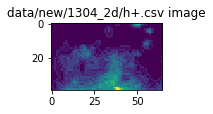

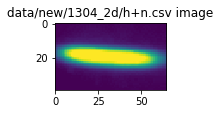

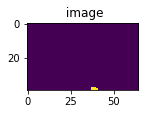

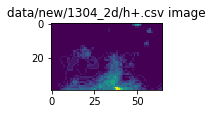

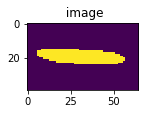

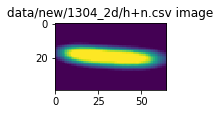

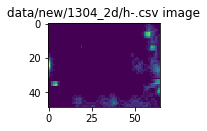

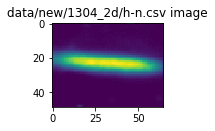

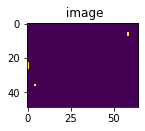

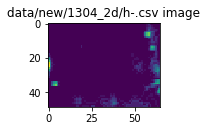

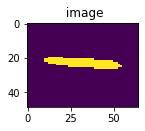

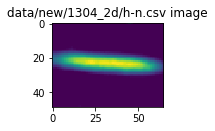

In [8]:
enrichment_analysis('data/new/1304_2d', 'h', 'h', threshold = 0.75, hard = False)

### 18/06 ASSAY
> DNA Pol $\Delta$ was used as the loading control.

Magnitude (normalized): 1.933495864890232
Magnitude (normalized): 0.810634108705781
Enrichment of c4: 2.385164705167856


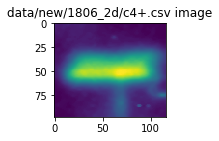

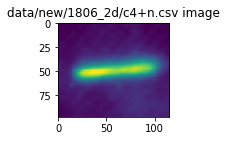

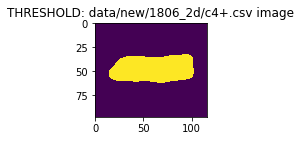

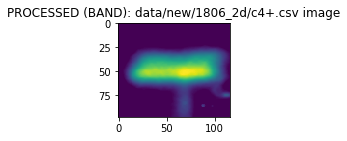

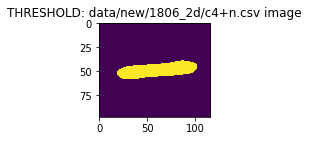

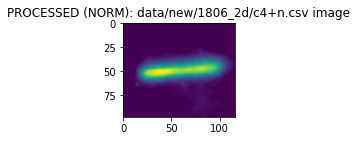

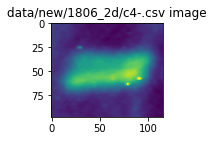

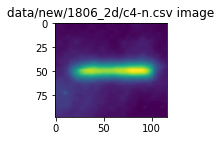

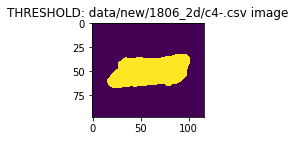

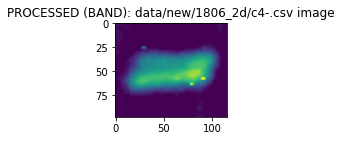

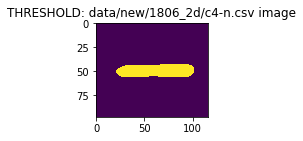

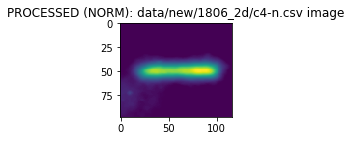

In [36]:
enrichment_analysis('data/new/1806_2d', 'c4', 'c4', threshold = 0.5, hard = False)

Magnitude (normalized): 1.9519242389286224
Magnitude (normalized): 0.2895046603247814
Enrichment of wt: 6.742289525629232


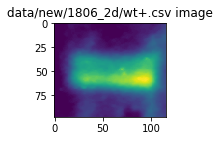

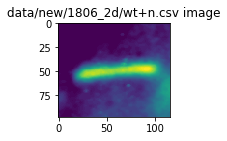

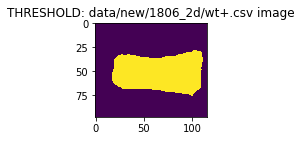

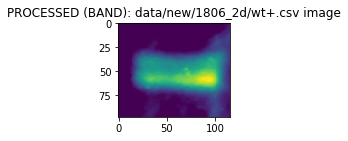

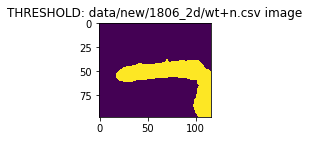

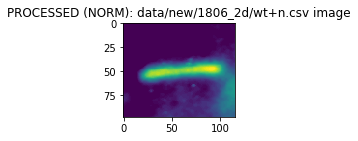

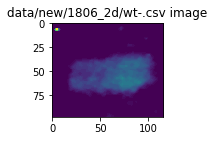

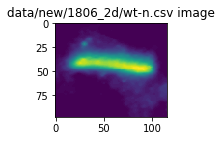

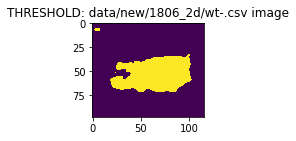

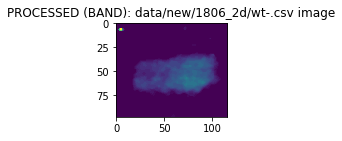

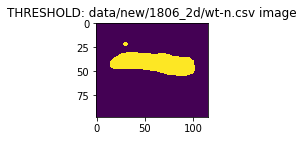

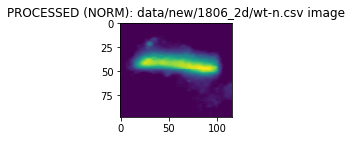

In [38]:
enrichment_analysis('data/new/1806_2d', 'wt', 'wt', threshold = 0.5, hard = False, method = 1)

Magnitude (normalized): 1.2210776624336828
Magnitude (normalized): 0.860318948528965
Enrichment of hp: 1.4193313590518597


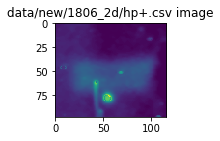

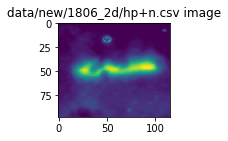

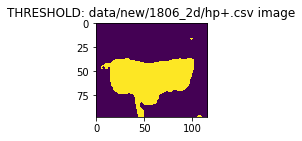

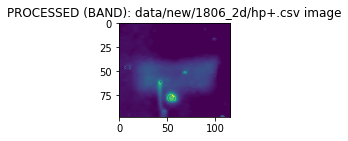

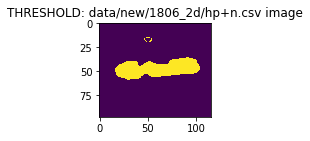

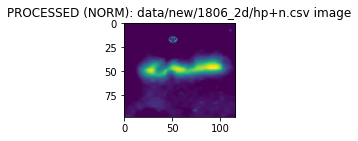

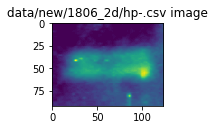

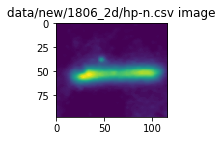

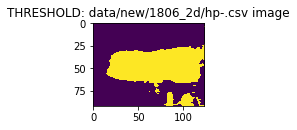

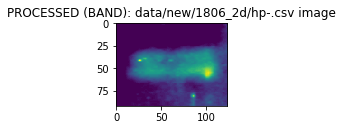

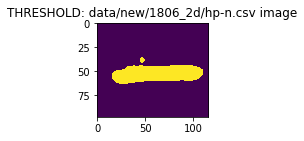

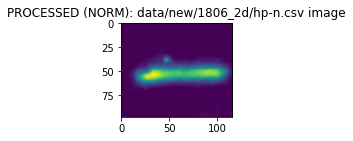

In [41]:
enrichment_analysis('data/new/1806_2d', 'hp', 'hp', threshold = 0.5, hard = False, method = 1)

Magnitude (normalized): 0.21132053918208818
Magnitude (normalized): 0.1407571748905525
Enrichment of h: 1.501312734831479


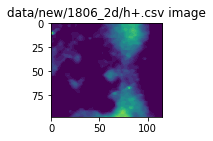

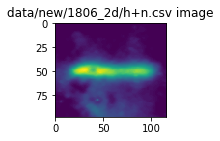

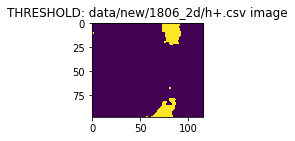

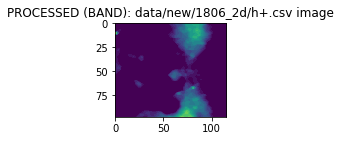

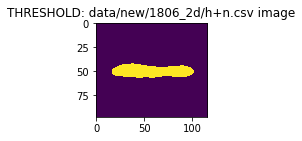

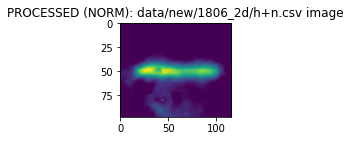

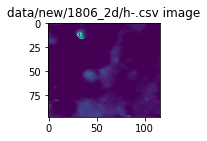

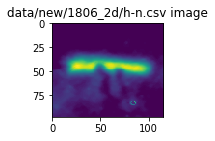

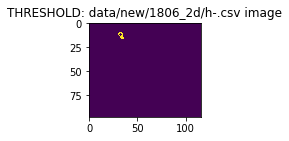

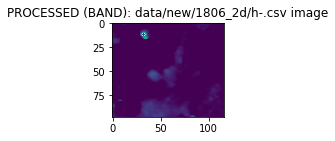

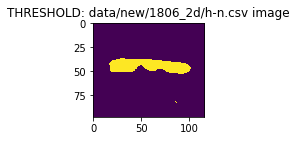

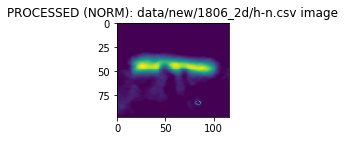

In [43]:
enrichment_analysis('data/new/1806_2d', 'h', 'h', threshold = 0.5, hard = False, method = 0)

Magnitude (normalized): 2.1679430579331473
Magnitude (normalized): 0.9239832763207906
Enrichment of _wt: 2.346301186928059


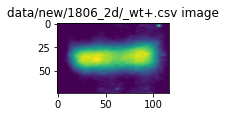

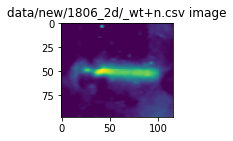

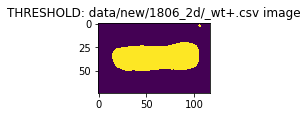

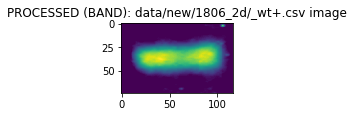

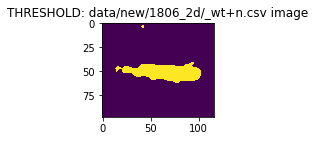

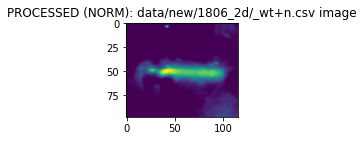

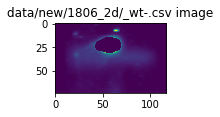

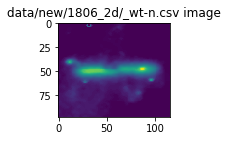

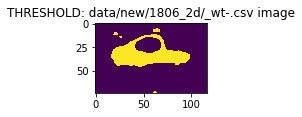

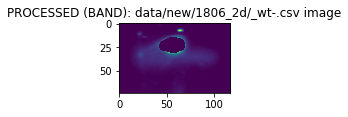

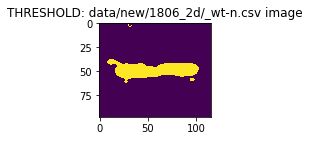

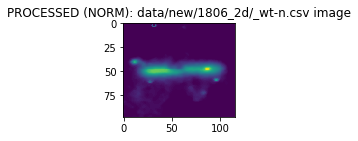

In [88]:
enrichment_analysis('data/new/1806_2d', '_wt', '_wt', threshold = 0.5, hard = False, method = 1)

Magnitude (normalized): 2.0157296586770985
Magnitude (normalized): 1.361807327144097
Enrichment of _c4: 1.4801871149455257


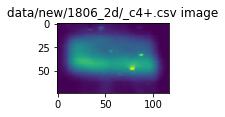

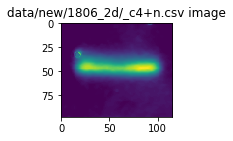

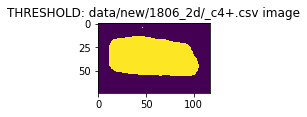

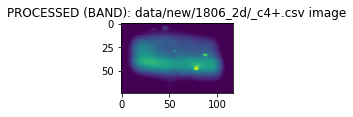

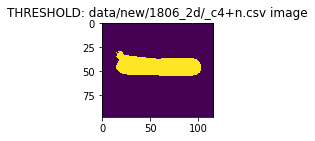

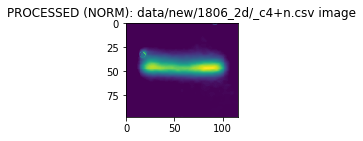

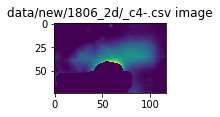

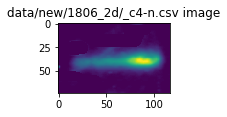

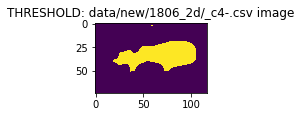

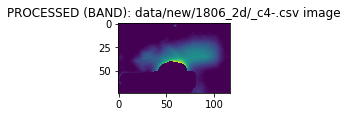

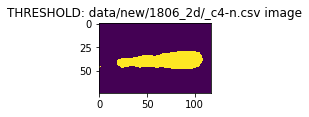

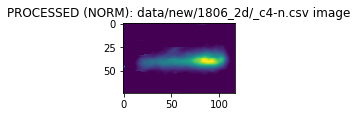

In [91]:
enrichment_analysis('data/new/1806_2d', '_c4', '_c4', threshold = 0.5, hard = False, method = 1)